# PRÁCTICA 4: DIAGNÓSTICO DE CÁNCER CON GÉNES

### Importación de las librerías necesarias

In [115]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

### Carga de la base de datos

In [116]:
df = pd.read_csv("Recursos Lab3/genes.csv")
df.head()

,Gene1,Gene2,CancerPresent
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


### Apartado 1
Creación de un set de entrenamiento, otro de validación y uno de test.
Para ello, primero vamos a dividir el dataset en dos:
 - X: Características de las observaciones
 - y: Etiquetas de los datos

In [117]:
X = df[['Gene1', 'Gene2']]
y = df['CancerPresent']

Vamos a visualizar como se comportan los datos del DataFrame:

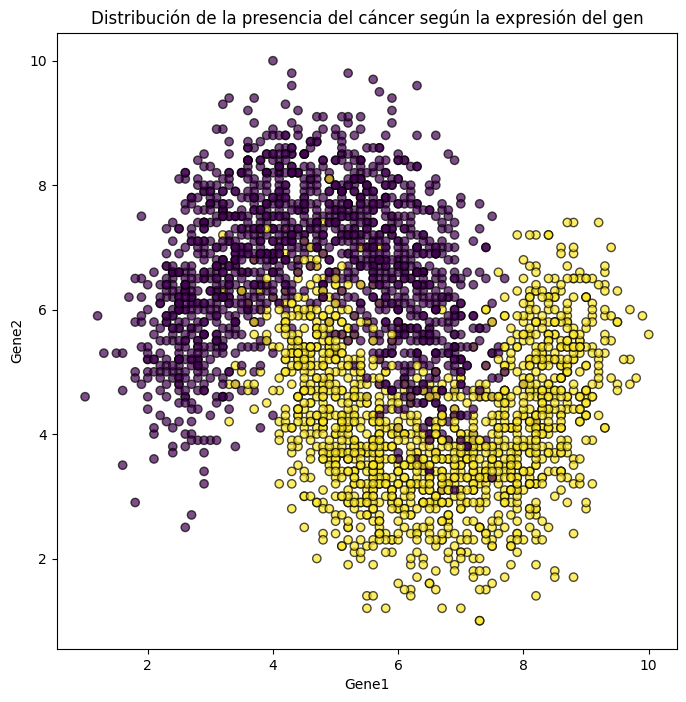

In [118]:
plt.figure(figsize=(8, 8))
scatter = plt.scatter(X['Gene1'], X['Gene2'], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.xlabel('Gene1')
plt.ylabel('Gene2')
plt.title('Distribución de la presencia del cáncer según la expresión del gen')
plt.grid(False)
plt.show()

<div style="text-align: justify">
Parece que los datos están algo mezclados, con algunas áreas donde los puntos morados y amarillos se superponen, dichas áreas van a provocar problemas en la clasificación. Sin embargo, hay regiones donde se podría trazar una línea o curva que separara en gran medida los dos conjuntos.
</div>

<div style="text-align: justify">
A continuación, dividimos los datos en conjuntos de entrenamiento y prueba. Dentro de los datos de entrenamiento, realizamos una segunda partición para crear datos de validación:
</div>

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) 
X_train.shape, y_train.shape, X_val.shape,y_val.shape, X_test.shape, y_test.shape

((1800, 2), (1800,), (600, 2), (600,), (600, 2), (600,))

### Apartados 2 y 3

A continuación, se normalizan los datos para facilitar la convergencia del algoritmo y reducir la complejidad del cómputo:

In [120]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

A continuación, se empleará el algoritmo de los K-vecinos. Dicho algoritmo acepta dos parámetros: el número K de vecinos cercanos y la métrica de distancia escogida. La función lo realiza de forma bruta con las distancias euclídea y de Manhattan. Además, solo emplea números impares para K con el fin de evitar empates en la elección de clase y $K \leq \sqrt{N}$ donde N es el número de observaciones de training:

In [121]:
def evaluate_knn(k_values, distance_metrics, X_train, y_train, X_val, y_val):
    results = []
    for k in k_values:
        for distance in distance_metrics:
            knn = KNeighborsClassifier(n_neighbors=k, metric=distance)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_val)
            accuracy = accuracy_score(y_val, y_pred)

            results.append({
                'k': k,
                'distance_metric': distance,
                'accuracy': accuracy
            })
    return pd.DataFrame(results)

k_values = range(1, round(math.sqrt(len(X_train))), 2)
distance_metrics = ['euclidean', 'manhattan']
knn_results = evaluate_knn(k_values, distance_metrics, X_train_scaled, y_train, X_val_scaled, y_val)
knn_results.sort_values(by='accuracy', ascending=False).head()

,k,distance_metric,accuracy
24,25,euclidean,0.945000
22,23,euclidean,0.943333
20,21,euclidean,0.943333
19,19,manhattan,0.943333
18,19,euclidean,0.943333



Podemos observar en la tabla que la configuración con K = 25 y distancia euclidiana tiene la mayor precisión en los datos de validación, con una puntuación del 94.5%.

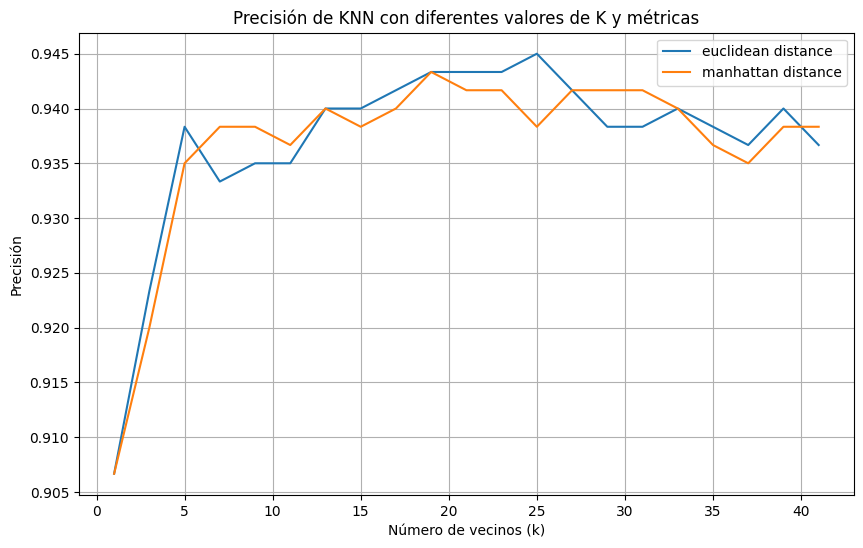

In [122]:
plt.figure(figsize=(10, 6))
for distance in distance_metrics:
    subset = knn_results[knn_results['distance_metric'] == distance]
    plt.plot(subset['k'], subset['accuracy'], label=f'{distance} distance')

plt.title('Precisión de KNN con diferentes valores de K y métricas')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

<div style="text-align: justify">
En la gráfica se observa que para valores bajos de K, la precisión aumenta rápidamente, lo que sugiere que un número pequeño de vecinos cercanos es suficiente para hacer una buena clasificación en este caso. A medida que k aumenta, la precisión parece estabilizarse y fluctúa ligeramente sin una tendencia clara a la baja o al alza, lo que puede indicar que agregar más vecinos no mejora significativamente la precisión del modelo.

Ambas métricas de distancia muestran un comportamiento similar en términos de precisión a lo largo de diferentes valores de k.
</div>

/tmp/ipykernel_610/1595385808.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


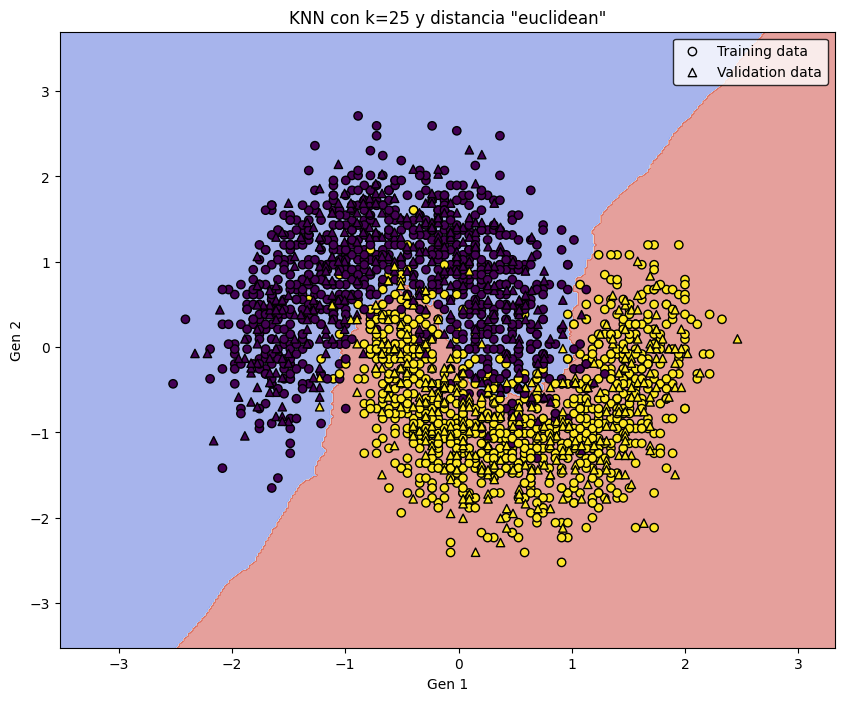

In [123]:
best_model_data = knn_results.sort_values(by='accuracy', ascending=False).iloc[0]
best_knn = KNeighborsClassifier(n_neighbors=best_model_data['k'], metric=best_model_data['distance_metric'])
best_knn.fit(X_train_scaled, y_train)

h = .02 
x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = best_knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, marker='o', label='Training data', edgecolors='k')
plt.scatter(X_val_scaled[:, 0], X_val_scaled[:, 1], c=y_val, marker='^', label='Validation data', edgecolors='k')
plt.xlabel('Gen 1')
plt.ylabel('Gen 2')
plt.title(f'KNN con k={best_model_data["k"]} y distancia "{best_model_data["distance_metric"]}"')

legend = plt.legend(edgecolor='black')
for handle in legend.legendHandles:
    handle.set_facecolor("none")

<div style="text-align: justify">
Podemos observar que, efectivamente, como se mencionó anteriormente, las áreas donde se superponen ambas categorías iban a ser problemáticas. No obstante, en general ha logrado clasificar correctamente ambas clases.
</div>

### Apartado 4

Creamos un nuevo .csv con los datos de test:

In [124]:
df_X = pd.DataFrame(X_test_scaled, columns=['Gene1', 'Gene2'])
df_y = pd.DataFrame(y_test, columns=['CancerPresent'])
df_y = df_y.reset_index()
df_pacientes_test = pd.concat([df_X, df_y], axis=1)
df_pacientes_test.to_csv('pacientes_test.csv', index=False)

Leemos el .csv recien generado y lo separamos en características y etiquetas:

In [125]:
df_test = pd.read_csv('pacientes_test.csv')
X_test = df_test[['Gene1', 'Gene2']]
y_test = df_test['CancerPresent']

Hacemos predicciones:

In [126]:
y_pred = best_knn.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(f'La precisión del modelo en los datos de test es: {test_accuracy}')

La precisión del modelo en los datos de test es: 0.9316666666666666


/home/vscode/.local/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


El modelo tiene una precisión del 93.16% con los datos de test, por tanto, se trata de un modelo bastante preciso.

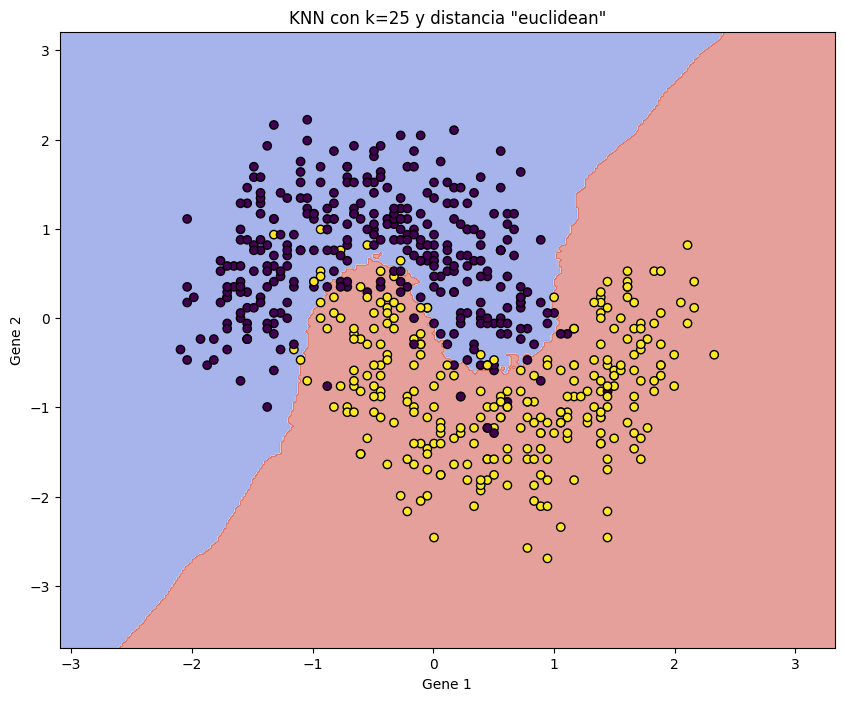

In [127]:
h = .02 
x_min, x_max = X_test['Gene1'].min() - 1, X_test['Gene1'].max() + 1
y_min, y_max = X_test['Gene2'].min() - 1, X_test['Gene2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = best_knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
plt.scatter(X_test['Gene1'], X_test['Gene2'], c=y_test, marker='o', edgecolors='k', label='Test data')
plt.xlabel('Gene 1')
plt.ylabel('Gene 2')
plt.title(f'KNN con k={best_model_data["k"]} y distancia "{best_model_data["distance_metric"]}"')
plt.show()